In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae
#from utils.metrics import log_rank, cox_estimation

In [2]:
n_samples = 600
n_features_bytype = 4
n_features_multiplier = 3 

In [3]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0

In [4]:
control, treated, types = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull")
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [5]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,0.232115,-0.005418,0.617265,0.293210,1.663366,0.326065,1.029122,1.653213,1.0,0.0,0.0,1.0,0.534592,0
1,2.391064,2.270207,1.321483,-0.223459,0.162198,0.503271,0.039587,0.496924,0.0,1.0,1.0,0.0,0.195617,0
2,1.218877,0.138211,-0.052931,-1.456686,2.849174,0.695739,0.257567,0.262227,0.0,0.0,0.0,0.0,0.077464,0
4,-0.057679,0.151849,-1.451763,-2.054206,1.770322,0.374070,1.250062,0.809636,1.0,0.0,0.0,1.0,0.261518,0
5,1.133604,-0.085758,-0.849618,-1.027719,0.016576,0.863162,0.208538,0.871970,1.0,0.0,0.0,0.0,0.107738,0


In [6]:
print(np.mean(control['censor']),np.mean(treated['censor']))

0.15081967213114755 0.13220338983050847


In [7]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [8]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

D

In [9]:
data = pd.concat([control,treated],ignore_index=True)
T = data['time']
C = data['censor']
D = np.sum(data['censor'])
print(D)

85


In [10]:
control

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,0.232115,-0.005418,0.617265,0.293210,1.663366,0.326065,1.029122,1.653213,1.0,0.0,0.0,1.0,0.534592,0
1,2.391064,2.270207,1.321483,-0.223459,0.162198,0.503271,0.039587,0.496924,0.0,1.0,1.0,0.0,0.195617,0
2,1.218877,0.138211,-0.052931,-1.456686,2.849174,0.695739,0.257567,0.262227,0.0,0.0,0.0,0.0,0.077464,0
4,-0.057679,0.151849,-1.451763,-2.054206,1.770322,0.374070,1.250062,0.809636,1.0,0.0,0.0,1.0,0.261518,0
5,1.133604,-0.085758,-0.849618,-1.027719,0.016576,0.863162,0.208538,0.871970,1.0,0.0,0.0,0.0,0.107738,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,-1.435795,-2.118925,-1.693247,-1.116545,0.800696,0.224585,0.822262,0.535233,0.0,1.0,1.0,0.0,0.897447,1
593,-0.419684,-0.250189,0.331401,0.642038,1.437196,0.705596,2.065962,0.507764,0.0,1.0,1.0,1.0,1.111120,0
596,-1.099414,0.060221,-0.365448,1.561889,0.451228,0.456815,0.416131,0.648513,1.0,1.0,1.0,1.0,0.073751,0
597,-1.318286,0.278845,-1.041861,-0.238151,1.134118,0.346216,0.556552,1.553769,0.0,0.0,0.0,0.0,0.419846,1


In [11]:
alpha = 0.05
p_treated = 0.5
treatment_effect = 0.5
expected_power = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2))

In [12]:
expected_power

0.6349235433798979

## Generation

In [13]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [14]:
data_init_control_encoded

tensor([[ 0.2321, -0.0054,  0.6173,  ...,  1.0000,  0.5346,  0.0000],
        [ 2.3911,  2.2702,  1.3215,  ...,  0.0000,  0.1956,  0.0000],
        [ 1.2189,  0.1382, -0.0529,  ...,  0.0000,  0.0775,  0.0000],
        ...,
        [-1.0994,  0.0602, -0.3654,  ...,  1.0000,  0.0738,  0.0000],
        [-1.3183,  0.2788, -1.0419,  ...,  0.0000,  0.4198,  1.0000],
        [-0.6283, -0.8155,  0.1641,  ...,  0.0000,  0.5912,  0.0000]])

In [15]:
data_init_control_encoded.shape

torch.Size([305, 18])

In [16]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [17]:
feat_types_dict

[{'': '0', 'name': 'feat1', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '1', 'name': 'feat2', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '2', 'name': 'feat3', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '3', 'name': 'feat4', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '4', 'name': 'feat5', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '5', 'name': 'feat6', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '6', 'name': 'feat7', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '7', 'name': 'feat8', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '8', 'name': 'feat9', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '9', 'name': 'feat10', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '10', 'name': 'feat11', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '11', 'name': 'feat12', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '12',
  'name': 'survcens',
  'type': 'surv_weibull',
  'dim': '2',
  'nclass': ''}]

In [18]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

In [19]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
#visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [20]:
names_cont = []
names_pos = []
names_cat = []
for x in range(1, n_features_bytype   + 1):
            names_pos.append("feat{0}".format(x + n_features_bytype))
            names_cat.append("feat{0}".format(x + 2 * n_features_bytype))

table1 = TableOne(df_init, categorical=names_cat, continuous=names_cont, 
                  groupby='treatment', nonnormal=names_pos, pval=True)
print(table1)

                          Grouped by treatment                                                     
                                       Missing        Overall              0              1 P-Value
n                                                         600            305            295        
feat1, mean (SD)                             0     -0.0 (1.0)      0.0 (1.0)     -0.0 (1.0)   0.910
feat2, mean (SD)                             0     -0.0 (1.0)      0.0 (0.9)     -0.0 (1.0)   0.360
feat3, mean (SD)                             0      0.0 (0.9)      0.1 (0.9)     -0.0 (0.9)   0.405
feat4, mean (SD)                             0      0.0 (1.0)      0.0 (1.0)     -0.0 (1.1)   0.303
feat5, median [Q1,Q3]                        0  0.7 [0.3,1.1]  0.6 [0.3,1.1]  0.7 [0.3,1.2]   0.540
feat6, median [Q1,Q3]                        0  0.7 [0.3,1.2]  0.6 [0.3,1.0]  0.7 [0.3,1.2]   0.144
feat7, median [Q1,Q3]                        0  0.7 [0.3,1.2]  0.7 [0.3,1.2]  0.8 [0.3,1.3]   0.267


In [21]:


# the datasets used for training is data_init_control
n_generated_sample = 10
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [22]:
data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample,verbose=False)

In [23]:
data_gen_control[1]

tensor([[-0.0543, -0.4695, -1.6908,  ...,  0.0000,  1.0410,  0.0000],
        [-2.7308, -2.0300, -0.0553,  ...,  0.0000,  0.5274,  0.0000],
        [ 1.2675, -0.0773, -0.5456,  ...,  0.0000,  0.1387,  0.0000],
        ...,
        [-1.3699,  0.0883,  1.5126,  ...,  1.0000,  0.1774,  0.0000],
        [-0.7234, -0.6780,  0.3549,  ...,  0.0000,  0.4559,  0.0000],
        [-0.0840, -0.7668,  1.2018,  ...,  0.0000,  0.2148,  1.0000]])

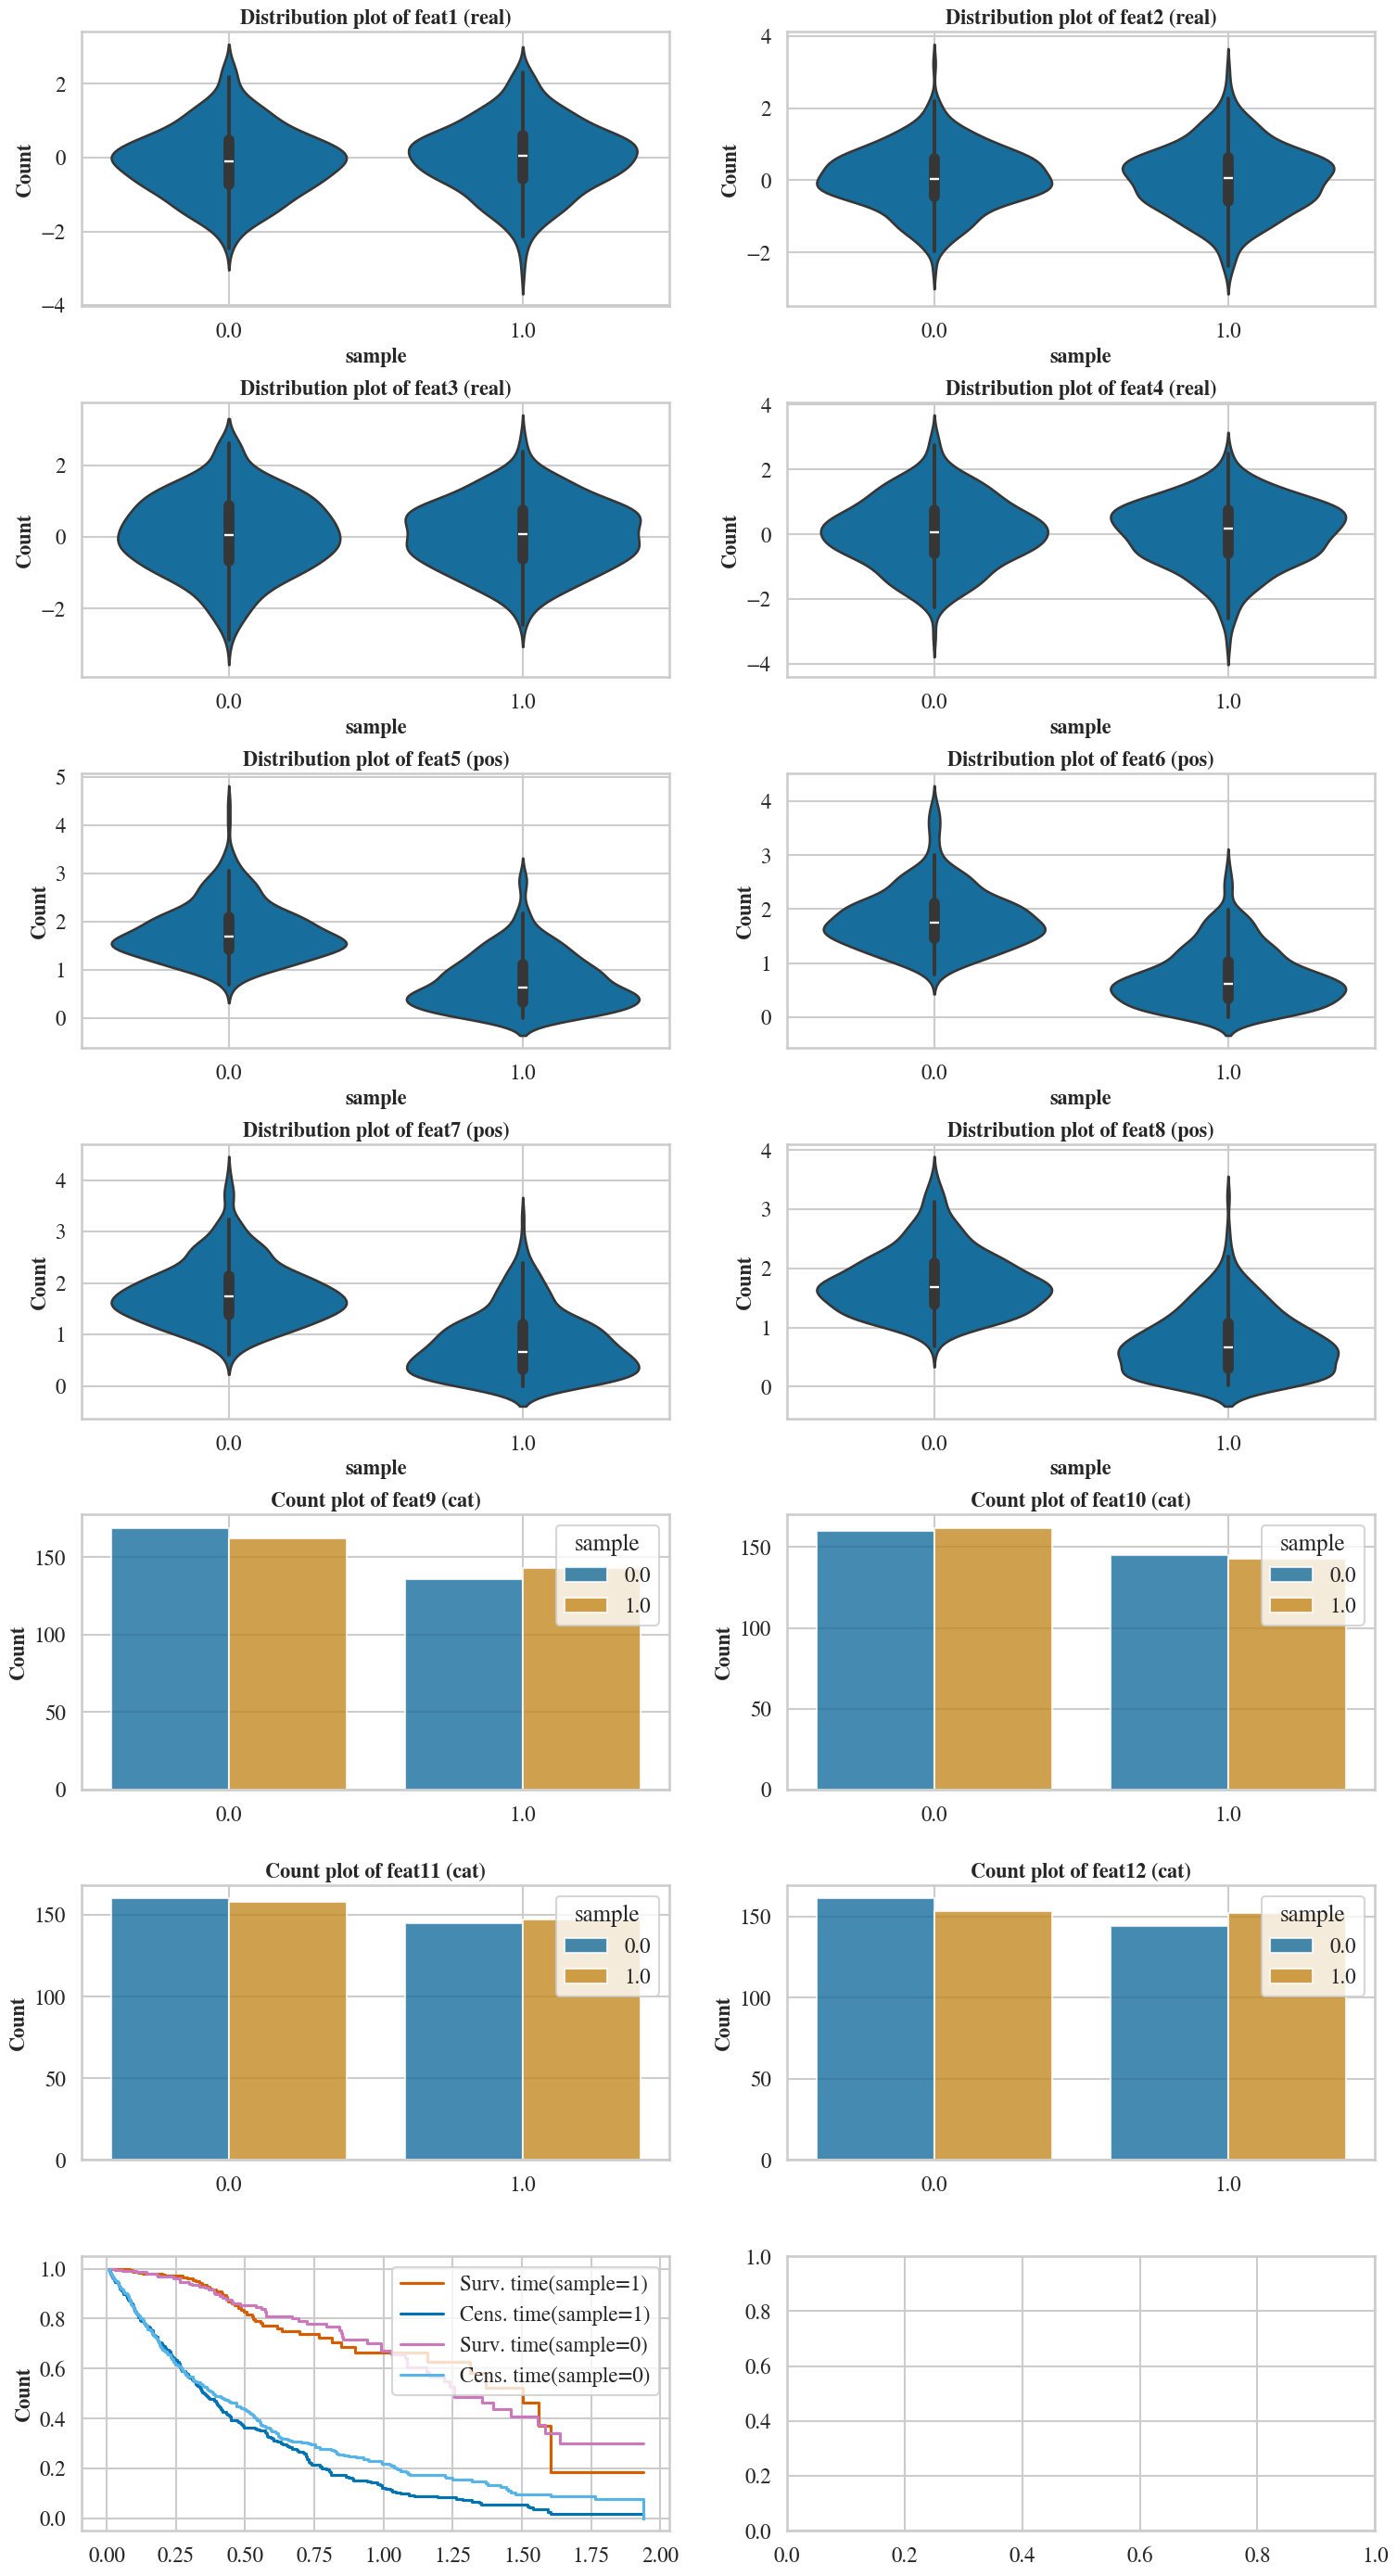

In [24]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=fnames)
df_init_control_ext['sample'] = 1

sel_idx = 0
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=fnames)
df_gen_control_ext_sel['sample'] = 0

# Save original values before overwriting
#tmp = df_gen_control_ext_sel[['time', 'censor']].copy()

# Replace 'time' with row-wise minimum
#df_gen_control_ext_sel['time'] = tmp.min(axis=1)

# Replace 'censor' with column name of the minimum ('time' or 'censor')
#df_gen_control_ext_sel['censor'] = 1* (tmp.idxmin(axis=1)=='time')
#df_gen_control_ext_sel[]

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [25]:
intervals

[(0.0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 1.25)]

## Replication

In [64]:
n_generated_dataset = 20
dataset_name = "Simulations"

In [40]:
alphas = np.arange(0,1.1,0.2)
print(alphas)

[0.  0.2 0.4 0.6 0.8 1. ]


In [41]:
M = 100
log_p_value = []
log_p_value_gen = []
log_p_value_aug = []
simu_num = []
treat_coef = []
D_init = []
D_eff = []
for t in alphas:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated, types = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull")
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')

        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
    
        data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample,verbose=False)
        
        for i in range(n_generated_dataset):
            
            D =  n_samples - np.sum(control['censor']) - np.sum(treated['censor'])
            D_init.append(D)
            
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control['treatment'] = 0
            
            df_gen_control_aug = pd.DataFrame(torch.cat([data_init_control, data_gen_control[i]]).numpy(), columns=fnames)
            df_gen_control_aug['treatment'] = 0
            log_p_value.append(p_value_init)
            simu_num.append(m)
            D =  n_samples - np.sum(df_gen_control['censor']) - np.sum(treated['censor'])
            D_eff.append(D)
            
            p_value_gen = compute_logrank_test(df_gen_control, treated)
            log_p_value_gen.append(p_value_gen)

            p_value_aug = compute_logrank_test(df_gen_control_aug, treated)
            log_p_value_aug.append(p_value_aug)
            
            treat_coef.append(treatment_effect)

            

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [44]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen" : log_p_value_gen ,
                        "log_pvalue_aug" : log_p_value_aug , "treat_coef" : treat_coef, "D_init" : D_init, "D_eff" : D_eff})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen"] = results['log_pvalue_gen'] > -np.log(0.05)
results["reject_H0_aug"] = results['log_pvalue_aug'] > -np.log(0.05)

In [45]:
results.head()

,XP_num,log_pvalue_init,log_pvalue_gen,log_pvalue_aug,treat_coef,D_init,D_eff,reject_H0_init,reject_H0_gen,reject_H0_aug
0,0,0.15874,0.659253,0.244115,0.0,525,518.0,False,False,False
1,0,0.15874,2.072933,0.865692,0.0,525,510.0,False,False,False
2,0,0.15874,0.659253,0.244115,0.0,525,518.0,False,False,False
3,0,0.15874,0.962944,0.383154,0.0,525,516.0,False,False,False
4,0,0.15874,0.520111,0.178705,0.0,525,519.0,False,False,False


# TODO "treat_coef" --> "treat_coeff"

In [47]:
results.groupby("treat_coef").mean()["D_init"].to_numpy()

array([507.28, 501.53, 496.1 , 489.12, 484.7 , 477.62])

In [48]:
results.to_csv("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [57]:
alpha = 0.05
p_treated = 0.5
D_means = results.groupby("treat_coef").mean()["D_init"].to_numpy()
expected_power = []
for i in np.arange(alphas.shape[0]):
    treat_E = alphas[i]
    D = D_means[i]
    expected_power.append(norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treat_E)**2 ) - norm.ppf(1 - alpha/2)))

In [61]:
D_means

array([507.28, 501.53, 496.1 , 489.12, 484.7 , 477.62])

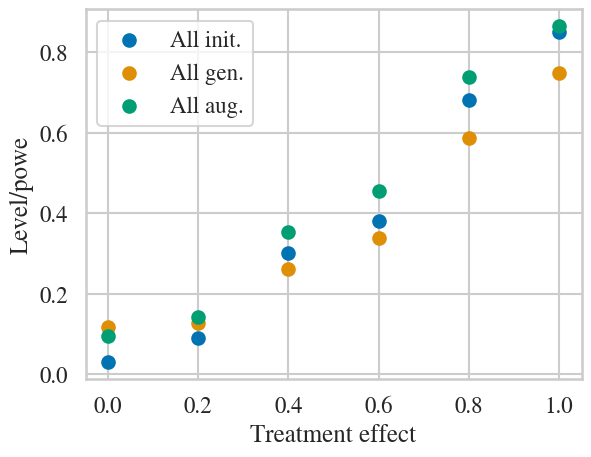

In [68]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("treat_coef").mean()["reject_H0_gen"].to_numpy()
puiss_aug = results.groupby("treat_coef").mean()["reject_H0_aug"].to_numpy()
#puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(alphas,puiss_init,label = "All init.")
plt.scatter(alphas,puiss_gen,label = "All gen.")
plt.scatter(alphas,puiss_aug,label = "All aug.")
#plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
#plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
#plt.plot(alphas,expected_power,label = "Expected level/power")
#plt.plot(np.arange(alphas.min(),alphas.max() + 0.01,0.01),expected_power,label = "Expected level/power")
plt.legend()
plt.xlabel("Treatment effect")
plt.ylabel("Level/powe")
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

## TODO point size should be proportional to sample size

#### Subsampling

In [87]:
M = 100
log_p_value = []
log_p_value_gen = []
log_p_value_aug = []
simu_num = []
treat_coef = []
p_choices = np.arange(0.2,0.6,0.2) 
D_init = []
D_eff = []
for t in alphas:
    treatment_effect = t
    for p in p_choices:
        for m in np.arange(M):
            if m % 10 == 0:
                print(m)
            control, treated, types = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull")
            control = control.sample(frac=1-p, replace=False)
            control = control.drop(columns='treatment')
            treated = treated.drop(columns='treatment')
    
            D =  n_samples - np.sum(control['censor']) - np.sum(treated['censor'])
            D_init.append(D)
            
            data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
            data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
            
            
            control.to_csv(data_file_control,index=False , header=False)
            treated.to_csv(data_file_treated,index=False , header=False)
            
            df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
            df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
            
            T_surv = torch.Tensor(df_init_control.time)
            T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
            n_intervals = 5
            T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
            T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
            intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
            
            p_value_init = compute_logrank_test(control, treated)
        
            
        
            # Load and transform control data
            data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                         feat_types_file_control, 
                                                                                                                         miss_file, true_miss_file)
            data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
            
            # Load and transform treated data
            data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                     miss_file, true_miss_file)
            data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
        
            data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                          true_miss_mask_control, feat_types_file_control, feat_types_dict, 
                                            n_generated_dataset, n_generated_sample = treated.shape[0] - control.shape[0],verbose=False)
            
            for i in range(n_generated_dataset):
                D =  n_samples - np.sum(control['censor']) - np.sum(treated['censor'])
                D_init.append(D)
                
                df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
                df_gen_control['treatment'] = 0
                
                df_gen_control_aug = pd.DataFrame(torch.cat([data_init_control, data_gen_control[i]]).numpy(), columns=fnames)
                df_gen_control_aug['treatment'] = 0
                log_p_value.append(p_value_init)
                simu_num.append(m)
                D =  treated.shape[0] + control.shape[0] + data_gen_control.shape[0] - np.sum(df_gen_control['censor']) - np.sum(treated['censor'])- np.sum(control['censor'])
                D_eff.append(D)
                
                p_value_gen = compute_logrank_test(df_gen_control, treated)
                log_p_value_gen.append(p_value_gen)
    
                p_value_aug = compute_logrank_test(df_gen_control_aug, treated)
                log_p_value_aug.append(p_value_aug)
                
                treat_coef.append(treatment_effect)

                 

0
10
20
30
40
50
60
70
80


RuntimeError: Trying to create tensor with negative dimension -1: [-1]

In [ ]:
results.to_csv("./dataset/" + dataset_name + "/results_sub_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [ ]:
p